<a href="https://colab.research.google.com/github/tokarchyn/diabetic-retinopathy-thesis/blob/master/diabetic-retinopathy-ml.ipynb" target="_parent">     
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [0]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import copy
import glob
from IPython.display import display, clear_output

if IN_COLAB:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

##  Define constants

In [0]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
CLASS_INDEXES = [0,1,2,3,4]
WIDTH = HEIGHT = 512
BATCH_SIZE = 16
PROJECT_DIR = 'drive/My Drive/diabetic-retinopathy-thesis'
BASE_IMAGE_DIR = os.path.join(PROJECT_DIR, 'train_processed')
TRAIN_LABELS_PATH = os.path.join(PROJECT_DIR, 'trainLabels.csv')

## Process dataframe 

In [0]:
def load_df():
  df = pd.read_csv(TRAIN_LABELS_PATH)
  print(df.head())
  return df

def add_features(df):
  df['image_path'] = BASE_IMAGE_DIR + '/' + df['image'].astype(str) + '.jpeg'
  df['level_categorical'] = df['level'].map(lambda x: to_categorical(x, len(CLASS_NAMES)))
  return df

def remove_unexist(df):
  all_images = glob.glob(BASE_IMAGE_DIR + "/*")
  while len(all_images) == 0:
    all_images = glob.glob(BASE_IMAGE_DIR + "/*")
  print('Found', len(all_images), 'images')
  df['exists'] = df['image_path'].map(lambda p: p in all_images)
  df = df[df['exists']].drop(columns=['exists'])
  print('Number of existed images is', len(df))
  return df

def train_val_split(df):
  train_img, val_img = train_test_split(df['image'], 
                                        test_size = 0.10, 
                                        random_state = 2020,
                                        stratify = df['level'].to_frame())
  train_df = df[df['image'].isin(train_img)]
  val_df = df[df['image'].isin(val_img)]
  print('train', train_df.shape[0], 'val', val_df.shape[0])
  return train_df, val_df

def calc_weights(df):
  level_counts = df['level'].value_counts().sort_index()
  weights = {cls: len(df) / count for cls, count in enumerate(level_counts)}
  print('Weights for each level:\n', weights)
  return weights

def get_samples_of_level(df, level, count):
  to_add = []
  it = iter(df[df['level']==level].iterrows())

  while count > len(to_add):
    _, row = None, None
    try:
      _, row = next(it)
    except StopIteration:
      it = iter(df[df['level']==level].iterrows())
      _, row = next(it)
    to_add.append(copy.deepcopy(row))

  return to_add

def balancing(df, multiplicators=None):
  max_level_count = df['level'].value_counts().max()

  for level in df['level'].unique():
    count_of_level = df[df['level']==level].count()[0]

    count_diff = 0
    if multiplicators != None:
      if level in multiplicators:
        count_diff = int(count_of_level * multiplicators[level]) - count_of_level
    else:
      if count_of_level == max_level_count:
        continue
      count_diff = max_level_count - count_of_level

    if count_diff == 0:
      continue
    print('Need to add(or remove)',count_diff, 'copies of level', level, 'where count of level is', count_of_level)
    if count_diff < 0:
      df_level = df[df['level'] == level] 
      df = df.drop(df_level.sample(count_diff * -1).index)
    else:    
      df = df.append(get_samples_of_level(df, level, count_diff), ignore_index=True)

  return df

def shrink_dataset_equally(df, number_of_each_level=None):
    levels = df['level'].unique()

    if number_of_each_level is None:
      number_of_each_level = df['level'].value_counts().min()

    def get_rows(df_tmp):
      size = len(df_tmp)
      return df_tmp.sample(number_of_each_level) if size >= number_of_each_level else df_tmp

    df_tmp = get_rows(df[df['level'] == levels[0]])
    for l in levels[1:]:
        df_tmp = df_tmp.append(get_rows(df[df['level'] == l]), ignore_index=True)
    return df_tmp

def shrink_dataset(df, count):
    return df[:count]

def shuffle(df):
  df = df.sample(frac=1).reset_index(drop=True)
  return df

def prepare_data():
  df = load_df()
  df = add_features(df)
  df = remove_unexist(df)
  # df = shrink_dataset(df, 7000)
  df = shuffle(df)

  weigths = calc_weights(df)
  train_df, val_df = train_val_split(df)
  # train_df = balancing(train_df)
  train_df = balancing(train_df, {3:2, 4:2})
  train_df = shrink_dataset_equally(train_df)
  train_df = shuffle(train_df)
  weigths = calc_weights(train_df)

  return train_df, val_df, weigths

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Found 35126 images
Number of existed images is 35126
Weights for each level:
 {0: 1.3609453700116234, 1: 14.378223495702006, 2: 6.637566137566138, 3: 40.235967926689575, 4: 49.612994350282484}
train 31613 val 3513
Need to add(or remove) 637 copies of level 4 where count of level is 637
Need to add(or remove) 786 copies of level 3 where count of level is 786
Weights for each level:
 {0: 5.0, 1: 5.0, 2: 5.0, 3: 5.0, 4: 5.0}


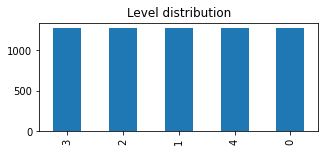

In [0]:
train_df, val_df, weigths = prepare_data()
train_df['level'].value_counts().plot(kind='bar', figsize=(5,2), title='Level distribution')

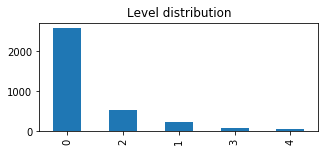

In [0]:
val_df['level'].value_counts().plot(kind='bar', figsize=(5,2), title='Level distribution')

## Build input pipeline

#### Augmentation functions

In [0]:
def rotate(x):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def flip(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

def color(x):
    x = tf.image.random_hue(x, 0.14)
    x = tf.image.random_saturation(x, 0.7, 1.5)
    x = tf.image.random_brightness(x, 0.1)
    x = tf.image.random_contrast(x, 0.8, 1.5)
    return x

def zoom(x):
    # Generate 20 crop settings, ranging from a 1% to 10% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(HEIGHT, WIDTH))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.7, lambda: x, lambda: random_crop(x))

def augment(dataset, aug_probability=1):
  # Add augmentations
  # augmentations = [flip, color, zoom, rotate]
  augmentations = [flip, rotate,color]

  def augment_map(img, level, aug_fun):
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return (tf.cond(choice < aug_probability, lambda: img, lambda: aug_fun(img)),
            level)
    
  # Add the augmentations to the dataset
  for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    dataset = dataset.map(lambda img, level: augment_map(img,level,f), num_parallel_calls=AUTOTUNE)

  # Make sure that the values are still in [0, 1]
  dataset = dataset.map(lambda img, level: (tf.clip_by_value(img, 0, 1),level), num_parallel_calls=AUTOTUNE)
  return dataset

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_label(level):
  return tf.cast(level == CLASS_INDEXES, dtype=tf.float32)

def process_path(file_path, level):
  label = get_label(level)
  # tf.print("Image:", file_path, '.Label: ', label, output_stream=sys.stdout)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def prepare(ds, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show_batch(image_batch, label_batch, predicted_labels=None):
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for i, (c_x, c_y, c_ax) in enumerate(zip(image_batch, label_batch, m_axs.flatten())):
        c_ax.imshow(c_x)
        real_level = CLASS_NAMES[c_y==1][0]
        pred_level = ''
        title = 'Real level: ' + real_level
        if predicted_labels is not None:
          pred_level = CLASS_NAMES[predicted_labels[i]]
          title = title + '\nPredicted one: ' + pred_level
        c_ax.set_title(title, color='g' if pred_level == '' or real_level == pred_level else 'r')
        c_ax.axis('off')     

def dataset_from_tensor_slices(df):
  return tf.data.Dataset.from_tensor_slices((
      df['image_path'].to_numpy(copy=True),
      df['level'].to_numpy(copy=True)))

def create_datasets(train_df, val_df):
  train_ds = dataset_from_tensor_slices(train_df)
  val_ds = dataset_from_tensor_slices(val_df)

  train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  # train_ds = train_ds.cache()
  # train_ds = train_ds.cache('train_cache')
  train_ds = augment(train_ds)
  train_ds = prepare(train_ds)

  val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  # val_ds = val_ds.cache()
  # val_ds = val_ds.cache('val_cache')
  val_ds = prepare(val_ds)
  
  return train_ds, len(train_df), val_ds, len(val_df)

train_ds, train_count, val_ds, val_count = create_datasets(train_df, val_df)

In [0]:
# train_batch, label_train_batch = next(iter(train_ds))
# show_batch(train_batch.numpy(), label_train_batch.numpy())

## Build model

In [0]:
def get_callbacks():
  return [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(PROJECT_DIR, 'models/model.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5'), 
        monitor='val_categorical_accuracy', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=10, 
        restore_best_weights=True),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', 
    #     factor=0.8, 
    #     patience=3, 
    #     verbose=1, 
    #     mode='auto', 
    #     epsilon=0.0001, 
    #     cooldown=5, 
    #     min_lr=0.0001)
    ]

def top_2_accuracy(in_gt, in_pred):
  return tf.keras.metrics.top_k_categorical_accuracy(in_gt, in_pred, k=2)

def get_input_shape():
  return (HEIGHT, WIDTH, 3)

class Recall(tf.keras.metrics.Metric):

    def __init__(self, name='recall_multi', **kwargs):
      super(Recall, self).__init__(name=name, **kwargs)
      self.builtin_metric = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
      non_healthy_gt = tf.math.greater(tf.math.argmax(y_true, axis=1), 0)
      non_healthy_pr = tf.math.greater(tf.math.argmax(y_pred, axis=1), 0)
      self.builtin_metric.update_state(non_healthy_gt, non_healthy_pr)

    def result(self):
      return self.builtin_metric.result()

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.builtin_metric.reset_states()

# also sensitivity
def recall_2(labels, predictions, features):
  recall = tf.keras.metrics.Recall()
  non_healthy_gt = tf.math.greater(labels, 0.001)
  non_healthy_pr = tf.math.greater(predictions, 0.001)
  m.update_state(non_healthy_gt, non_healthy_pr)
  return {'recall': recall}

def get_metrics():
  return ['categorical_accuracy', Recall(), top_2_accuracy, tf.keras.metrics.AUC()]

In [0]:
def get_model():
  model = models.Sequential()

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=get_input_shape()))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(CLASS_NAMES), activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=get_metrics())
  return model

def get_vgg_model():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), padding = "same", activation = "relu", input_shape = get_input_shape()))
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = "relu"))
  model.add(Dropout(0.5))
  # model.add(Dropout(0.2))
  model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=get_metrics())
  return model

def get_alex_model():
  model = Sequential()

  model.add(Conv2D(96, (11, 11), strides=4, activation = "relu",  padding = "same", input_shape = get_input_shape()))
  model.add(MaxPooling2D((3, 3), strides=2))
  # model.add(BatchNormalization())

  model.add(Conv2D(256, (5, 5), strides=1,  padding = "same", activation = "relu"))
  model.add(Conv2D(256, (5, 5), strides=1,  padding = "same", activation = "relu"))
  model.add(MaxPooling2D((3, 3), strides=2))
  model.add(BatchNormalization())

  # model.add(Conv2D(384, (3, 3), strides=1,  padding = "same", activation = "relu"))
  # model.add(Conv2D(384, (3, 3), strides=1,  padding = "same", activation = "relu"))
  # model.add(MaxPooling((2, 2), strides=2))
  # model.add(BatchNormalization())

  model.add(Conv2D(384, (3, 3),  padding = "same", activation = "relu"))
  model.add(Conv2D(384, (3, 3),  padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3),  padding = "same", activation = "relu"))
  model.add(MaxPooling2D((3, 3), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(384, (3, 3),  padding = "same", activation = "relu"))
  model.add(Conv2D(384, (3, 3),  padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3),  padding = "same", activation = "relu"))
  model.add(MaxPooling2D((3, 3), strides=2))
  model.add(BatchNormalization())

  # model.add(Conv2D(256, (3, 3), strides=1, padding = "same",  activation = "relu"))
  # model.add(Conv2D(256, (3, 3),  padding = "same", activation = "relu"))
  # model.add(Conv2D(256, (3, 3),  padding = "same", activation = "relu"))
  # model.add(MaxPooling2D((2, 2), strides=2))
  # model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(2096, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(2096, activation = "relu"))
  model.add(Dropout(0.5)) 
  model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=get_metrics())
  return model

def train_inception_v3(train, train_count, val, val_count, weights, epochs):
  # create the base pre-trained model
  base_model = InceptionV3(weights='imagenet', 
                           include_top=False, 
                           input_shape=(HEIGHT, WIDTH, 3))

  # add a global spatial average pooling layer
  x = base_model.output
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  # x = Conv2D(256, (3, 3), strides=1,  padding = "same", activation = "relu")(x)
  # x = Conv2D(256, (3, 3), strides=1,  padding = "same", activation = "relu")(x)
  # x = MaxPooling2D((3, 3), strides=2)(x)
  # x = BatchNormalization()(x)

  # let's add a fully-connected layer
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False
    
  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

  # train the model on the new data for a few epochs
  model.fit(train, steps_per_epoch=train_count // BATCH_SIZE, epochs=5,
          class_weight=weigths)

  # at this point, the top layers are well trained and we can start fine-tuning
  # convolutional layers from inception V3. We will freeze the bottom N layers
  # and train the remaining top layers.

  # let's visualize layer names and layer indices to see how many layers
  # we should freeze:
  # for i, layer in enumerate(base_model.layers):
  #   print(i, layer.name)

  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249 layers and unfreeze the rest:
  for layer in model.layers[:249]:
    layer.trainable = False
  for layer in model.layers[249:]:
    layer.trainable = True

  # we need to recompile the model for these modifications to take effect
  # we use SGD with a low learning rate
  model.compile(optimizer=SGD(lr=0.00003, momentum=0.9), 
                loss='categorical_crossentropy',
                metrics=get_metrics())

  # we train our model again (this time fine-tuning the top 2 inception blocks
  # alongside the top Dense layers
  history = model.fit(train_ds, steps_per_epoch=train_count // BATCH_SIZE, 
                      validation_data=val_ds, validation_steps=val_count // BATCH_SIZE,
                      epochs=epochs,
                      class_weight=weigths,
                      callbacks=get_callbacks())
  
  return model, history

In [0]:
try:
  del model
except:
  print('There is no model defined')
model = get_model()
# model = get_vgg_model()
# model = get_alex_model()
model.summary()

There is no model defined
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (

In [0]:
history = model.fit(train_ds, steps_per_epoch=train_count // BATCH_SIZE, epochs=70,
          validation_data=val_ds, validation_steps=val_count // BATCH_SIZE,
          class_weight=None,
          callbacks=get_callbacks())

Train for 398 steps, validate for 219 steps
Epoch 1/70
398/398 [==============================] - 1163s 3s/step - loss: 2.0462 - categorical_accuracy: 0.2189 - recall_multi: 0.8137 - top_2_accuracy: 0.4246 - auc: 0.5226 - val_loss: 2.0964 - val_categorical_accuracy: 0.0203 - val_recall_multi: 1.0000 - val_top_2_accuracy: 0.1150 - val_auc: 0.3010
Epoch 2/70
398/398 [==============================] - 64s 161ms/step - loss: 1.8318 - categorical_accuracy: 0.2403 - recall_multi: 0.7996 - top_2_accuracy: 0.4454 - auc: 0.5469 - val_loss: 1.6167 - val_categorical_accuracy: 0.2631 - val_recall_multi: 0.8333 - val_top_2_accuracy: 0.4692 - val_auc: 0.5547
Epoch 3/70
398/398 [==============================] - 68s 171ms/step - loss: 1.7104 - categorical_accuracy: 0.2525 - recall_multi: 0.8108 - top_2_accuracy: 0.4802 - auc: 0.5768 - val_loss: 1.4707 - val_categorical_accuracy: 0.4161 - val_recall_multi: 0.6821 - val_top_2_accuracy: 0.6484 - val_auc: 0.7107
Epoch 4/70
398/398 [======================

In [0]:
try:
  del model
except:
  print('There is no model defined')
model, history = train_inception_v3(train_ds, train_count, val_ds, val_count, None, 30)

87916544/87910968 [==============================] - 3s 0us/step
Train for 398 steps
Epoch 1/5
398/398 [==============================] - 203s 510ms/step - loss: 7.1341
Epoch 2/5
398/398 [==============================] - 195s 489ms/step - loss: 6.3320
Epoch 3/5
398/398 [==============================] - 194s 487ms/step - loss: 5.9257
Epoch 4/5
398/398 [==============================] - 192s 482ms/step - loss: 5.6199
Epoch 5/5
398/398 [==============================] - 191s 479ms/step - loss: 5.3844
Tensor("y_pred:0", shape=(None, 5), dtype=float32)
Train for 398 steps, validate for 219 steps
Epoch 1/30
Tensor("y_pred:0", shape=(None, 5), dtype=float32)
398/398 [==============================] - 362s 909ms/step - loss: 4.4003 - categorical_accuracy: 0.6340 - recall_multi: 0.8799 - top_2_accuracy: 0.8492 - auc_4: 0.9004 - val_loss: 4.5714 - val_categorical_accuracy: 0.7120 - val_recall_multi: 0.2166 - val_top_2_accuracy: 0.8730 - val_auc_4: 0.9001
Epoch 2/30
398/398 [===================

Load model from file

In [0]:
loaded_model = tf.keras.models.load_model(
    os.path.join(PROJECT_DIR, 'models', 'model.42-0.68.hdf5'),
    {'top_2_accuracy' : top_2_accuracy}
)

## Validation

16/16 [==============================] - 2s 136ms/sample - loss: 2.5620 - categorical_accuracy: 0.5000 - top_2_accuracy: 0.6250 - auc_1: 0.7197
Labels: [0 0 0 2 0 0 0 0 0 0 3 1 0 0 3 0]
Predicted labels: [0 4 0 4 4 0 0 0 0 0 4 0 2 4 4 0]


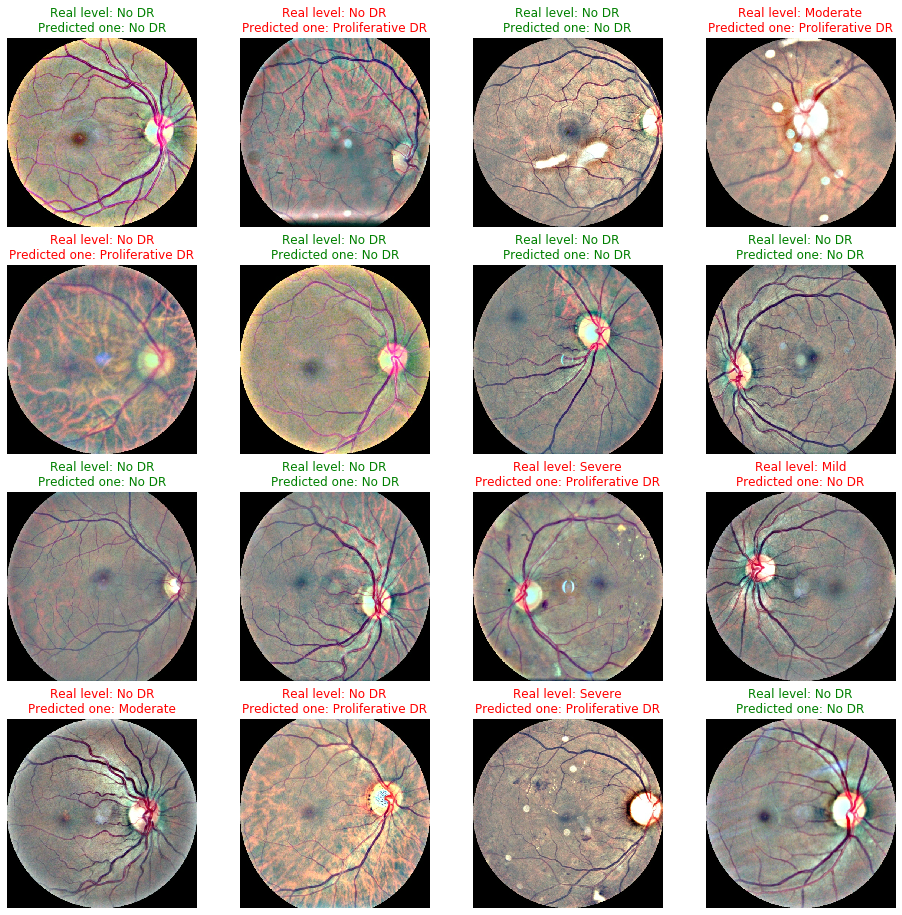

In [0]:
model_to_val = model

image_batch, label_batch = next(iter(val_ds))
model_to_val.evaluate(image_batch, label_batch, BATCH_SIZE)
predicted_labels = model_to_val.predict(image_batch)
predicted_labels = np.argmax(predicted_labels,axis=1)
print('Labels:', np.argmax(label_batch,axis=1))
print('Predicted labels:', predicted_labels)
show_batch(image_batch.numpy(), label_batch.numpy(),predicted_labels)

# What is going on with model?

In [0]:
np.set_printoptions(threshold=sys.maxsize)

### 1. Check input data <font color='green'>OK</font>

In [0]:
it = iter(train_ds)
imgs_1, labels_1 = next(it)
imgs_2, labels_2 = next(it)

Max: 1.0 Min: 0.0 Mean: 0.41460884 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.4462203 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.43273282 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.4946505 Size: (256, 256) Type: float32
Max: 1.0 Min: 0.0 Mean: 0.512242 Size: (256, 256) Type: float32


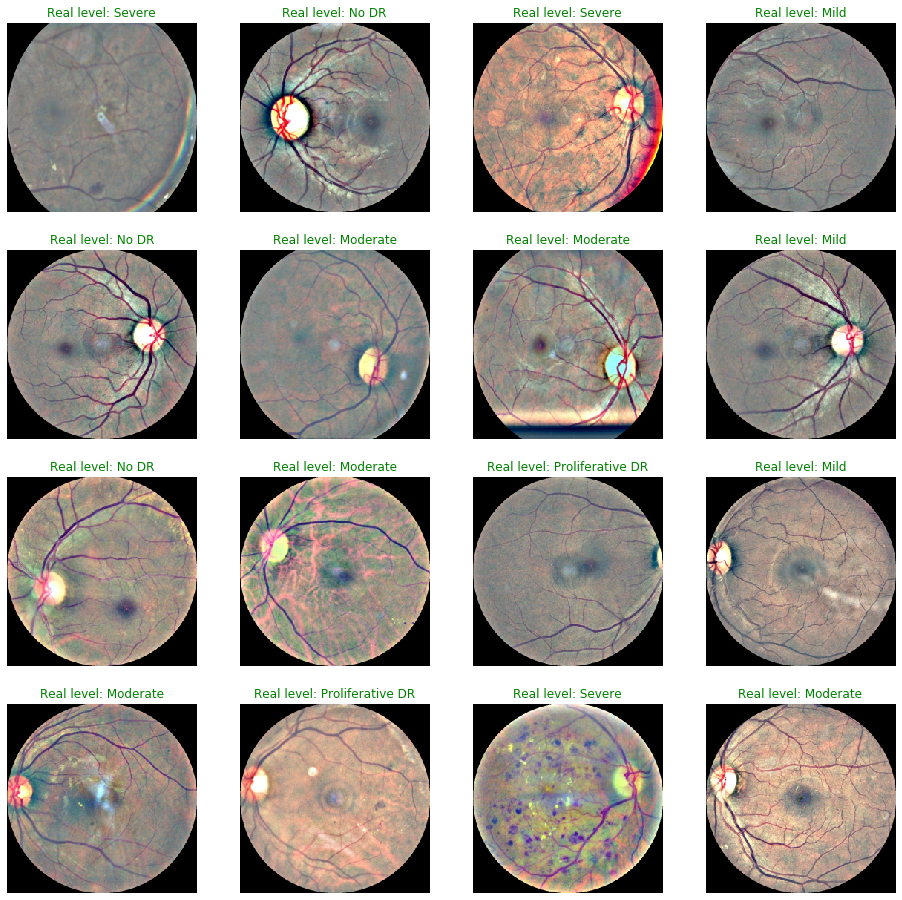

In [0]:
def print_info(img):
  img = img.numpy()
  print('Max:', img.max(), 'Min:', img.min(), 'Mean:',img.mean(), 
        'Size:', img.shape[:2], 'Type:', img.dtype)

print_info(imgs_1[23])
print_info(imgs_1[0])
print_info(imgs_2[10])
print_info(imgs_1[2])
print_info(imgs_1[15])

# print('Labels_1:', labels_1)

show_batch(imgs_1.numpy(), labels_1.numpy())

### 2.  Correctness of loss [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck) <font color='green'>OK</font>

Loss should be equal -ln(1/len(classes))

In [0]:
-np.log(1/len(CLASS_NAMES))

1.6094379124341003

### 3. Overfit a tiny subset of data [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck) <font color='green'>OK</font> 

### 4. Visualizing filters <font color='orange'>OK?</font> 

In [0]:
model_to_visualize = loaded_model

layer_outputs = [layer.output for layer in model_to_visualize.layers[:]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_to_visualize.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(image_batch) # Returns a list of five Numpy arrays: one array per layer activation
# first_layer_activation = activations[1]
# plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

layer_names = []
for layer in model_to_visualize.layers[:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 4. Visualizing loss per epoch <font color='orange'>OK?</font> 

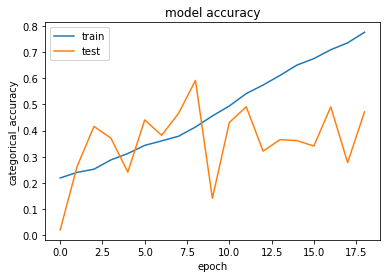

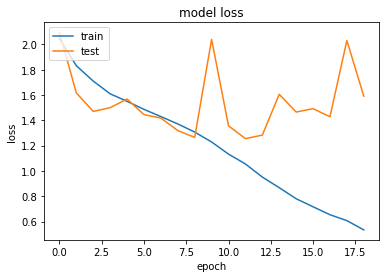

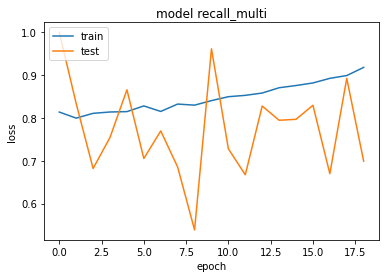

In [0]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_multi'])
plt.plot(history.history['val_recall_multi'])
plt.title('model recall_multi')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()